<a href="https://colab.research.google.com/github/Pam-Pam29/Formative-2-Multimodal-Data-Preprocessing/blob/main/models%20/product_recommendation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product Recommendation Model

This notebook demonstrates a complete machine learning pipeline for predicting customer product categories based on their social profiles and transaction data.

#### 1. Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelBinarizer,
    LabelEncoder,
    label_binarize
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    log_loss,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    roc_auc_score,
    precision_score,
    recall_score
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.utils.class_weight import compute_class_weight
import joblib
import shap
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

#### 2. Data Loading and Initial Exploration
This cell defines a function `load_and_explore_data` to load the `customer_social_profiles.csv` and `customer_transactions.csv` datasets into pandas DataFrames.

In [ ]:
def load_and_explore_data():
    print("Loading datasets...")
    social_profiles = pd.read_csv('customer_social_profiles.csv')
    transactions = pd.read_csv('customer_transactions.csv')

    print("\n=== Social Profiles Data ===")
    print(f"Shape: {social_profiles.shape}")
    print("\nMissing values:")
    print(social_profiles.isnull().sum())

    print("\n=== Transactions Data ===")
    print(f"Shape: {transactions.shape}")
    print("\nMissing values:")
    print(transactions.isnull().sum())

    return social_profiles, transactions

social_profiles, transactions = load_and_explore_data()

Loading datasets...

=== Social Profiles Data ===
Shape: (155, 5)

Missing values:
customer_id_new            0
social_media_platform      0
engagement_score           0
purchase_interest_score    0
review_sentiment           0
dtype: int64

=== Transactions Data ===
Shape: (150, 6)

Missing values:
customer_id_legacy     0
transaction_id         0
purchase_amount        0
purchase_date          0
product_category       0
customer_rating       10
dtype: int64


#### 3. Displaying the first 5 rows of the datasets

In [ ]:
print("Social Profiles Data (First 5 rows):")
display(social_profiles.head())

print("\nTransactions Data (First 5 rows):")
display(transactions.head())

Social Profiles Data (First 5 rows):


,customer_id_new,social_media_platform,engagement_score,purchase_interest_score,review_sentiment
0,A178,LinkedIn,74,4.9,Positive
1,A190,Twitter,82,4.8,Neutral
2,A150,Facebook,96,1.6,Positive
3,A162,Twitter,89,2.6,Positive
4,A197,Twitter,92,2.3,Neutral



Transactions Data (First 5 rows):


,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating,days_since_purchase
0,151,1001,408,2024-01-01,Sports,2.3,149
1,192,1002,332,2024-01-02,Electronics,4.2,148
2,114,1003,442,2024-01-03,Electronics,2.1,147
3,171,1004,256,2024-01-04,Clothing,2.8,146
4,160,1005,64,2024-01-05,Clothing,1.3,145


#### 4. Data Preprocessing
The `preprocess_data` function in this cell handles initial data cleaning steps, including imputing missing values in `review_sentiment` (with 'Neutral') and `customer_rating` (with the median), and converting the `purchase_date` column to datetime objects.

In [ ]:
def preprocess_data(social_profiles, transactions):
    # Handle missing values
    social_profiles['review_sentiment'].fillna('Neutral', inplace=True)
    transactions['customer_rating'].fillna(
        transactions['customer_rating'].median(), inplace=True
    )

    # Convert dates
    transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])

    return social_profiles, transactions

social_profiles, transactions = preprocess_data(social_profiles, transactions)

#### 5. Feature Engineering
In this cell, the  `create_features` function performs feature engineering on both the social profiles and transactions data separately. It aggregates various metrics like mean, std, max, and min, count for numerical columns and extracts mode for categorical columns, creating new features like 'engagement_interest_ratio' and 'avg_days_between_purchases'.

In [ ]:
def create_features(social_profiles, transactions):
    social_features = social_profiles.groupby('customer_id_new').agg({
        'engagement_score': ['mean', 'std', 'max', 'min'],
        'purchase_interest_score': ['mean', 'max', 'min'],
        'review_sentiment': lambda x: x.mode()[0] if not x.empty else 'Neutral',
        'social_media_platform': lambda x: x.mode()[0] if not x.empty else None
    }).reset_index()

    social_features.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0]
                             for col in social_features.columns]

    latest_date = transactions['purchase_date'].max()
    transactions['days_since_purchase'] = (latest_date - transactions['purchase_date']).dt.days

    transaction_features = transactions.groupby('customer_id_legacy').agg({
        'purchase_amount': ['mean', 'sum', 'count', 'std'],
        'product_category': lambda x: x.mode()[0] if not x.empty else None,
        'customer_rating': ['mean', 'count'],
        'days_since_purchase': 'min',
        'purchase_date': lambda x: (latest_date - x.max()).days
    }).reset_index()

    transaction_features.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0]
                                  for col in transaction_features.columns]

    social_features['engagement_interest_ratio'] = (
        social_features['engagement_score_mean'] /
        (social_features['purchase_interest_score_mean'] + 1e-6)
    )

    transaction_features['avg_days_between_purchases'] = (
        transaction_features['days_since_purchase_min'] /
        (transaction_features['purchase_amount_count'] + 1)
    )

    return social_features, transaction_features

social_features, transaction_features = create_features(social_profiles, transactions)

#### 6. Data Merging
This is where the `merge_datasets` function prepares the customer IDs for merging by cleaning and converting them to a consistent format. Then, it merges the `social_features` and `transaction_features` DataFrames based on customer IDs, resulting in a single `merged_data` DataFrame that combines information from both sources.

In [ ]:
def merge_datasets(social_features, transaction_features):
    social_features['customer_id_legacy_mapped'] = (
        social_features['customer_id_new'].str.replace('A', '').astype(int)
    )

    transaction_features['customer_id_legacy'] = (
        transaction_features['customer_id_legacy'].astype(int)
    )

    # Merge datasets
    merged_data = pd.merge(
        social_features,
        transaction_features,
        left_on='customer_id_legacy_mapped',
        right_on='customer_id_legacy',
        how='inner'
    )

    merged_data = merged_data.drop([
        'customer_id_new',
        'customer_id_legacy_mapped',
        'customer_id_legacy'
    ], axis=1)

    return merged_data

merged_data = merge_datasets(social_features, transaction_features)

#### 7. Data Visualization

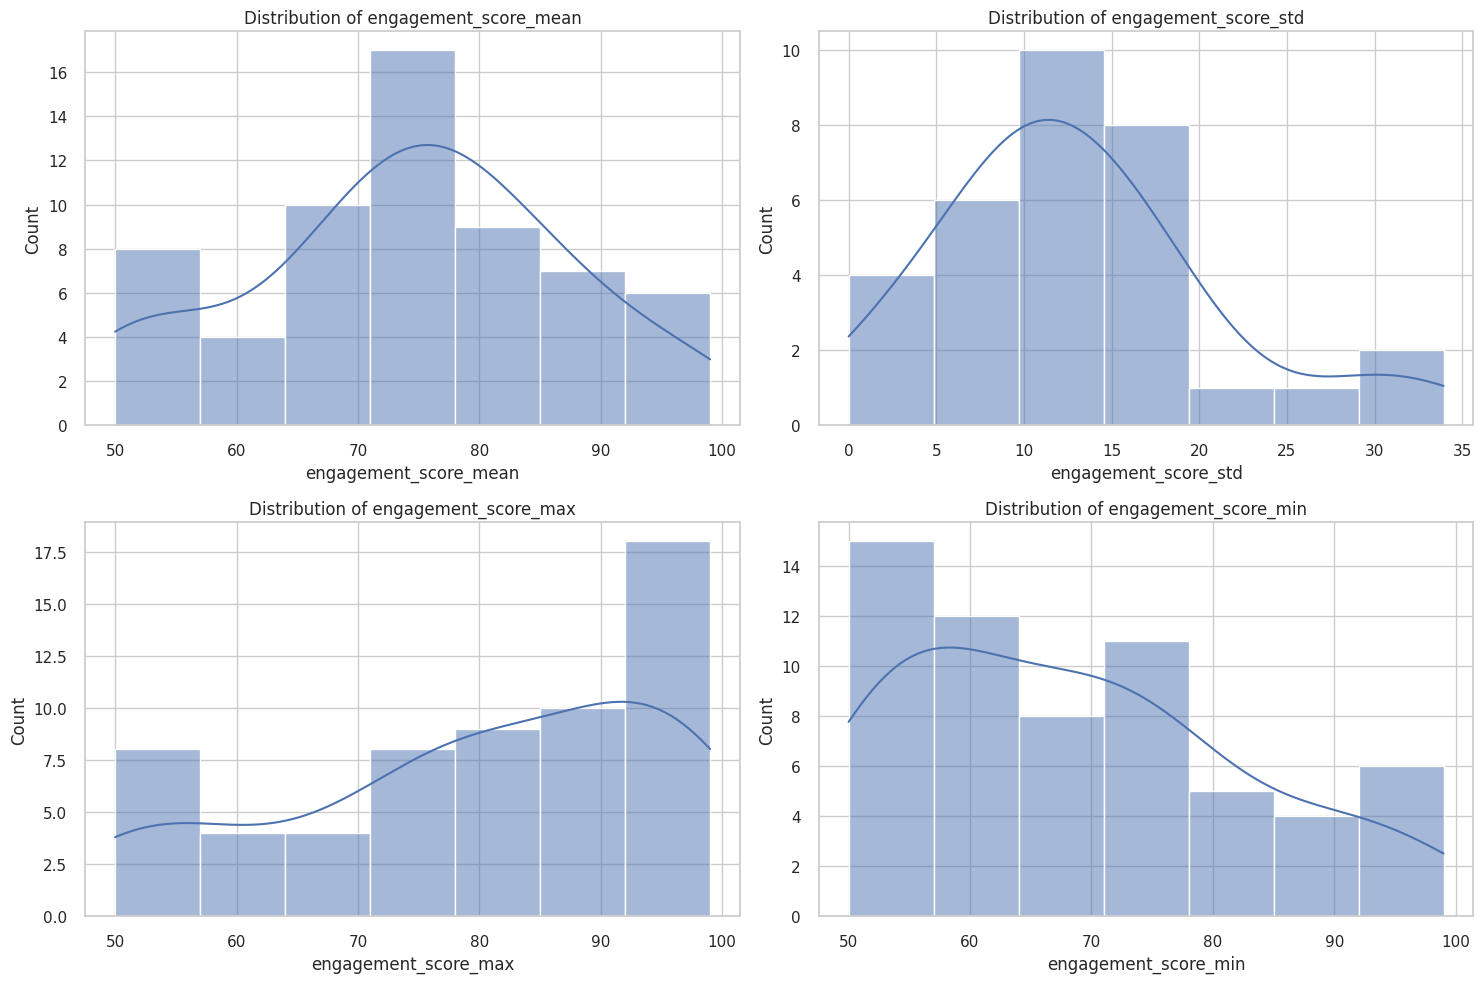

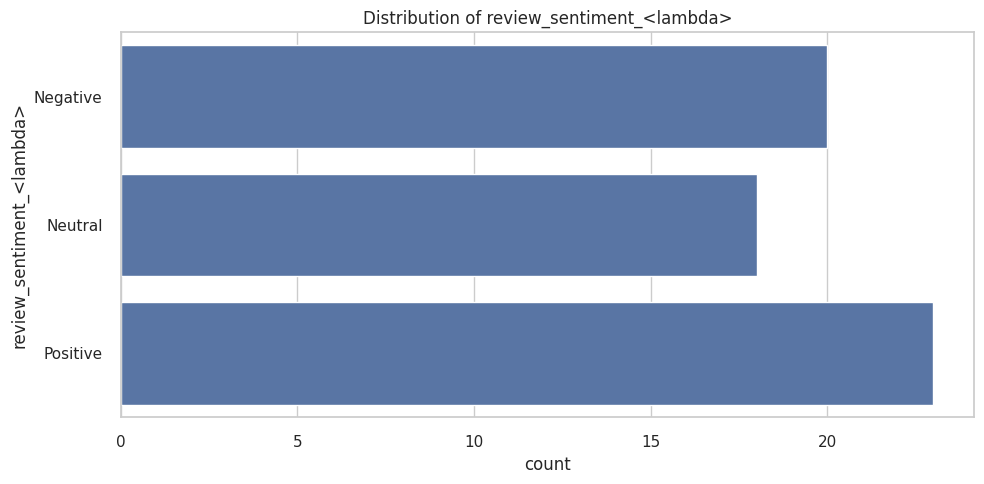

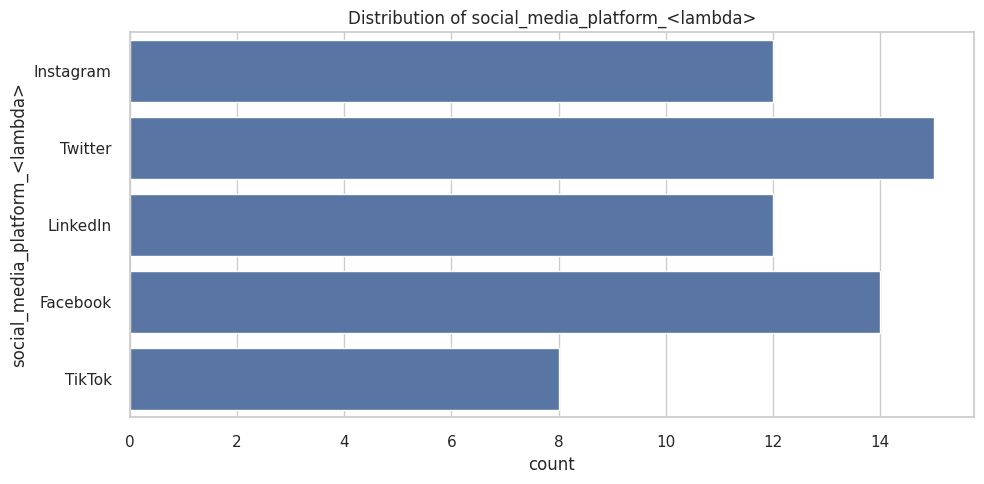

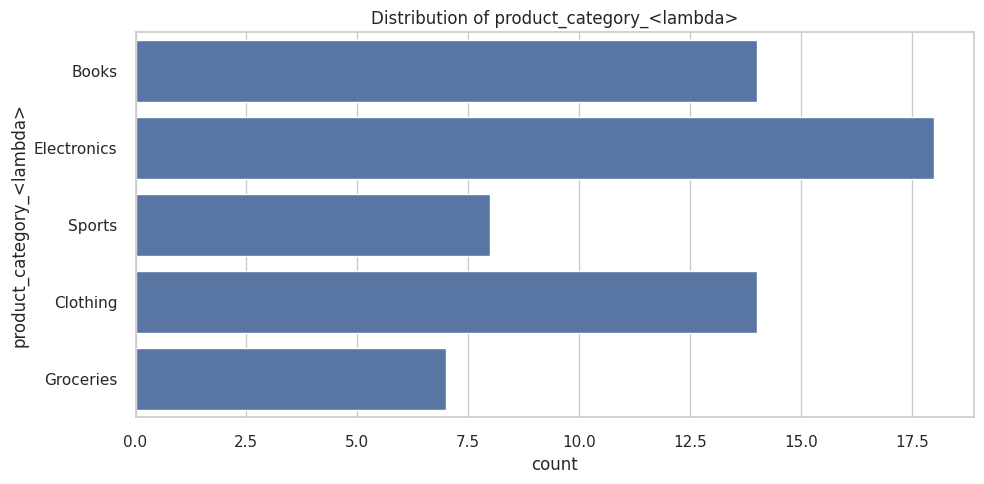

In [ ]:
def plot_distributions(data):
    num_cols = data.select_dtypes(include=['int64', 'float64']).columns
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(num_cols[:4], 1):
        plt.subplot(2, 2, i)
        sns.histplot(data[col], kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.savefig('distributions.png')
    plt.show()

    cat_cols = data.select_dtypes(include=['object']).columns
    for col in cat_cols:
        plt.figure(figsize=(10, 5))
        sns.countplot(data=data, y=col)
        plt.title(f'Distribution of {col}')
        plt.tight_layout()
        plt.savefig(f'{col}_distribution.png')
        plt.show()

plot_distributions(merged_data)

#### 8. Correlation Analysis
A heatmap is generated to show the correlation coefficients between different features, helping identify highly correlated variables.

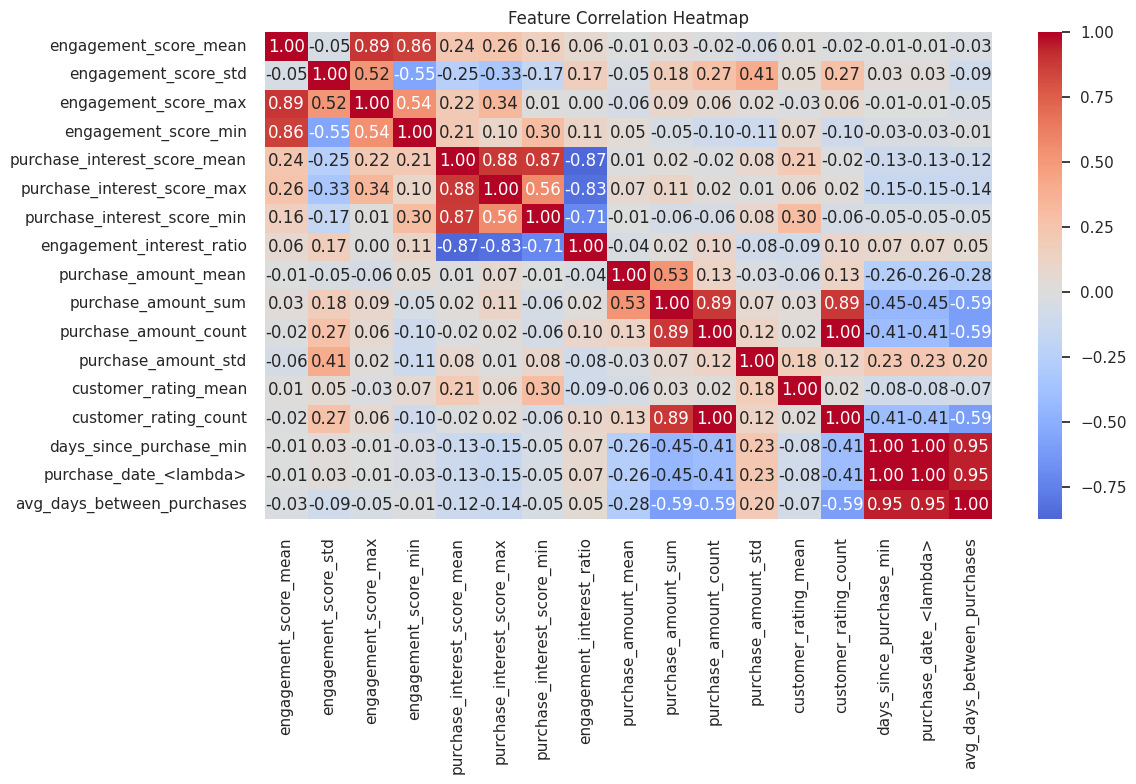

In [ ]:
plt.figure(figsize=(12, 8))
corr = merged_data.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

#### 9. Prepare Data for Modeling
The `prepare_data` function separates the features (X) from the target variable (y), encodes the target using `LabelEncoder`, and sets up a `ColumnTransformer`. The `ColumnTransformer` is configured to apply `SimpleImputer` and `StandardScaler` to numerical columns and `OneHotEncoder` to categorical columns, preparing the data for machine learning models.

In [ ]:
def prepare_data(merged_data):
    X = merged_data.drop(['product_category_<lambda>',
                         'social_media_platform_<lambda>'], axis=1)
    y = merged_data['product_category_<lambda>']

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median', fill_value=0)), ('scaler', StandardScaler())]), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ])

    return X, y_encoded, numerical_cols, categorical_cols, preprocessor, le

X, y, numerical_cols, categorical_cols, preprocessor, label_encoder = prepare_data(merged_data)

#### 10. Model Training with Cross-Validation
This cell splits the data into training, defines several classification models which are RandomForest, LogisticRegression, and XGBoost. It sets up pipelines including SMOTE for handling class imbalance. It then uses `GridSearchCV` with `StratifiedKFold` for hyperparameter tuning and cross-validation for each model. Finally, it evaluates the best models and generates learning curves, confusion matrices, and feature importance plots.


Training RandomForest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters for RandomForest:
{'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}

Cross-validation results:
Mean CV score: 0.3163 (±0.1065)
Training score: 1.0000 (±0.0000)

Test set results:
Accuracy: 0.2308
F1-score: 0.2385
Log Loss: 1.5694


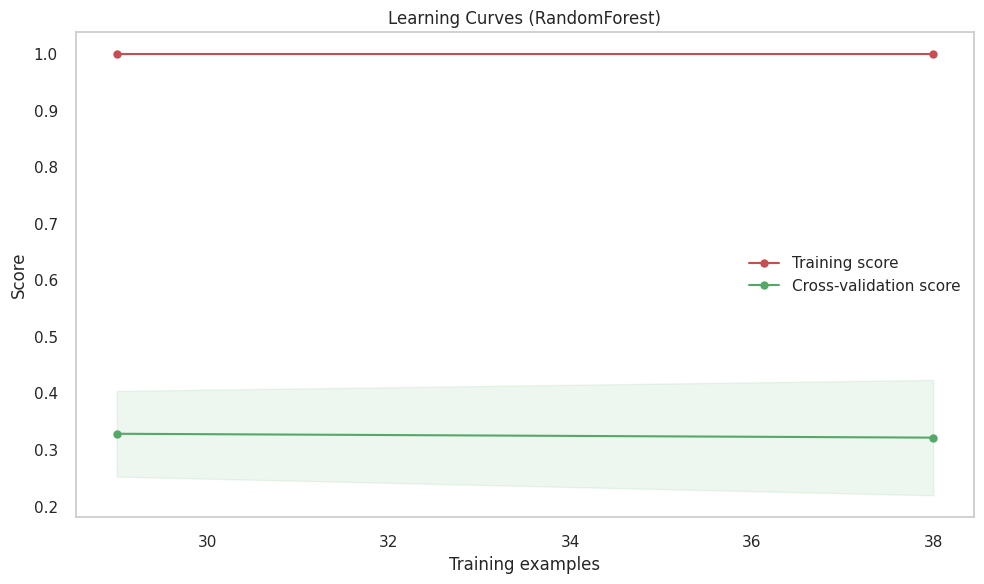

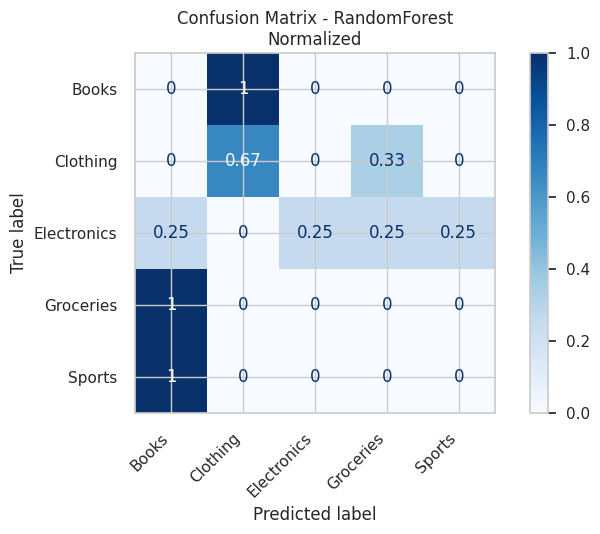

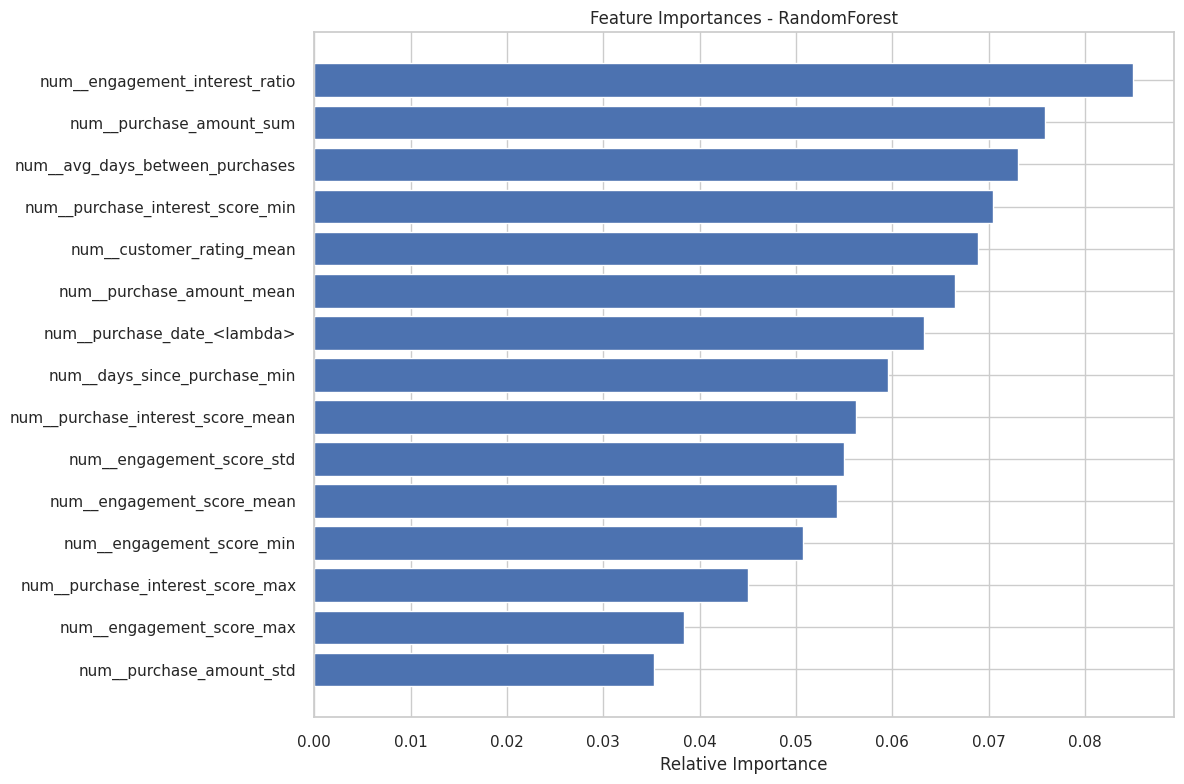


Training LogisticRegression...
Fitting 5 folds for each of 84 candidates, totalling 420 fits

Best parameters for LogisticRegression:
{'classifier__C': np.float64(0.01), 'classifier__l1_ratio': 0, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}

Cross-validation results:
Mean CV score: 0.3051 (±0.1113)
Training score: 0.5247 (±0.0511)

Test set results:
Accuracy: 0.1538
F1-score: 0.0923
Log Loss: 1.4847


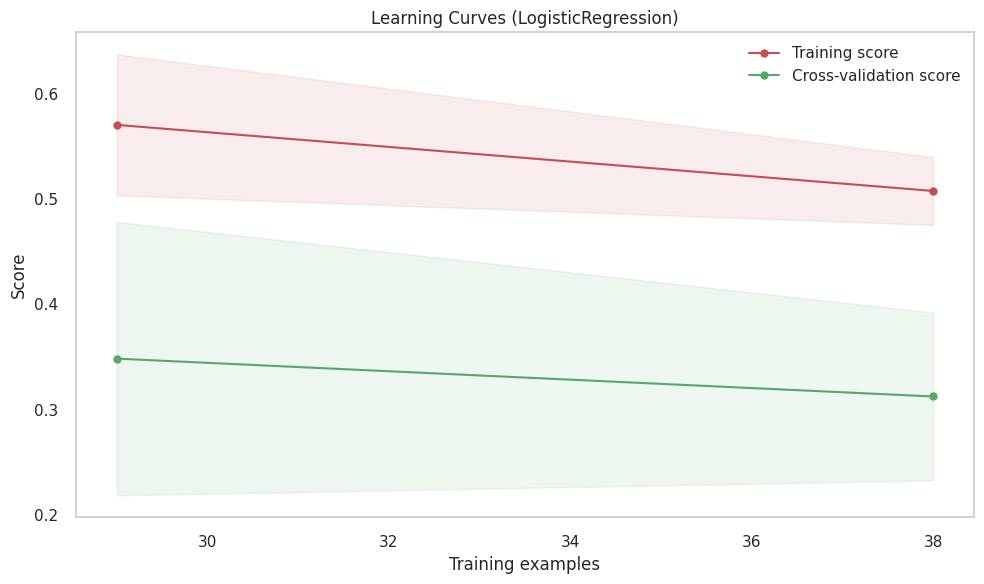

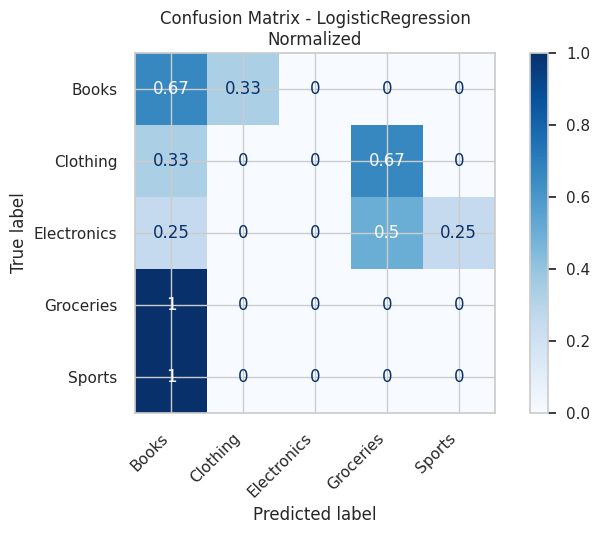


Training XGBoost...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters for XGBoost:
{'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__subsample': 1.0}

Cross-validation results:
Mean CV score: 0.3032 (±0.0778)
Training score: 0.9686 (±0.0100)

Test set results:
Accuracy: 0.2308
F1-score: 0.2335
Log Loss: 1.5021


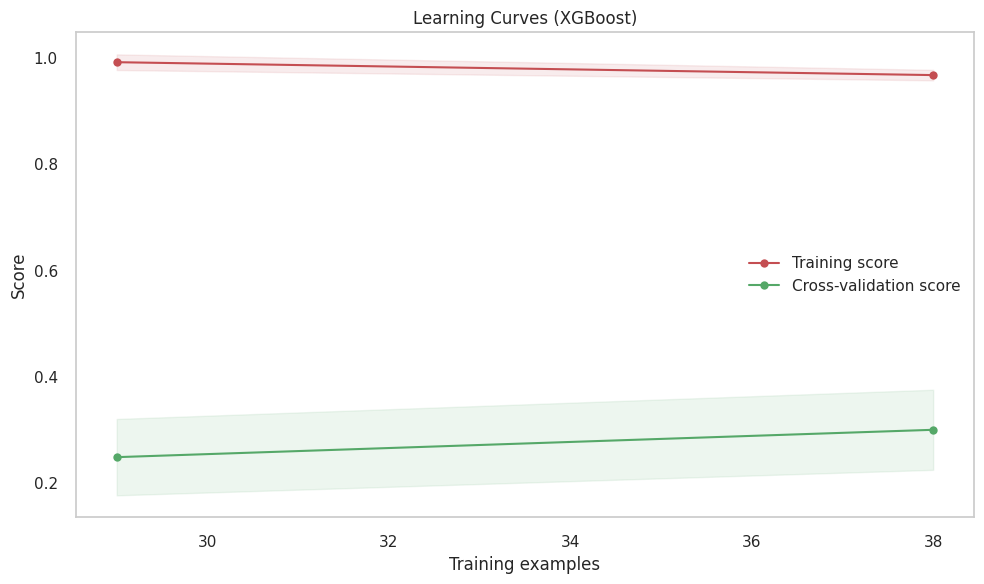

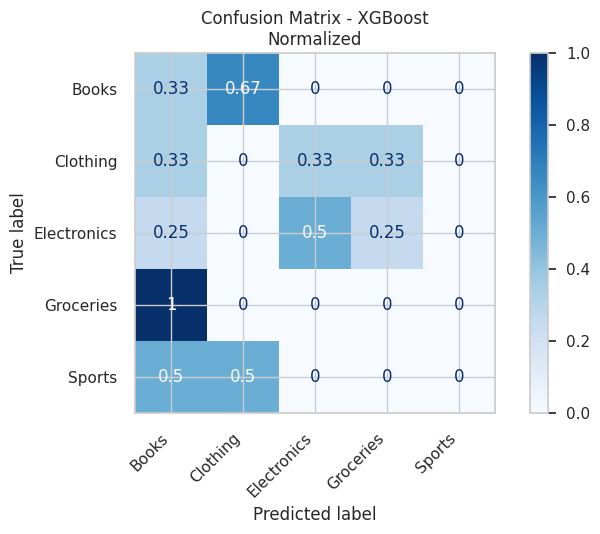

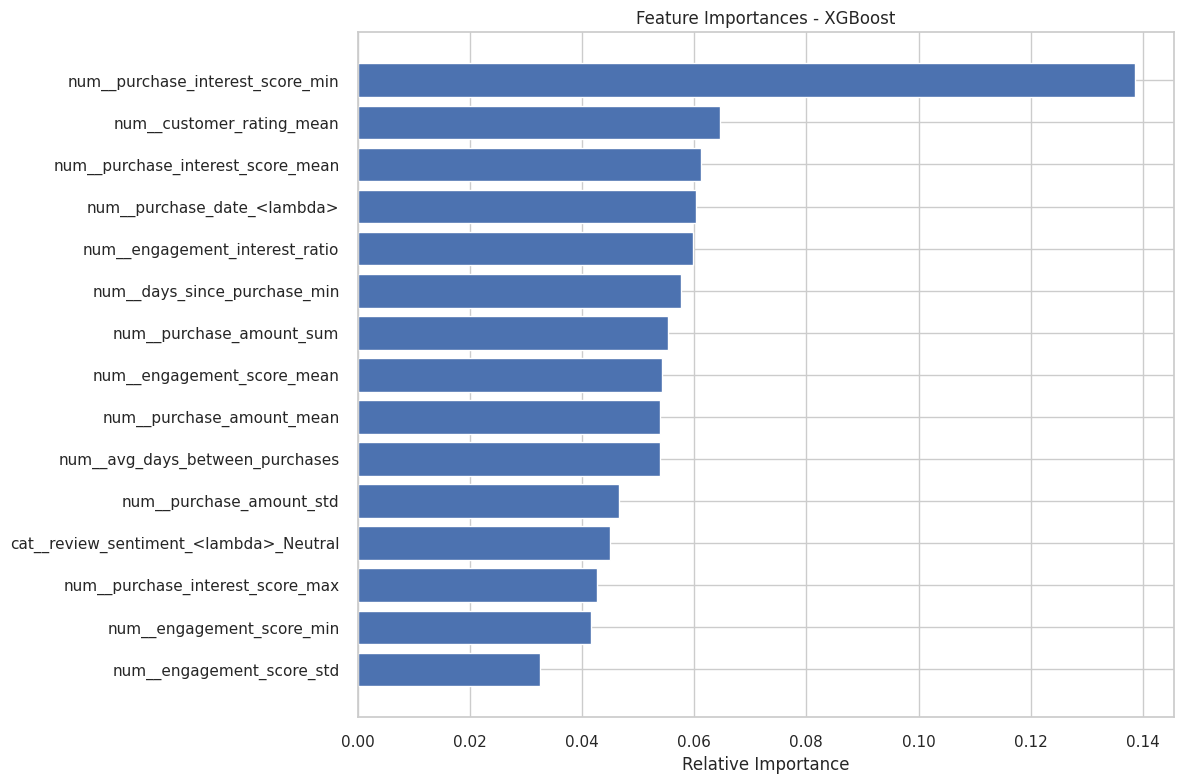

In [ ]:
def train_models(X, y, preprocessor, numerical_cols, categorical_cols):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    fitted_preprocessor_for_external_use = preprocessor.fit(X_train)
    X_test_processed_for_eval = fitted_preprocessor_for_external_use.transform(X_test)

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weight_ratio = np.median(class_weights) / class_weights
    xgb_weights = np.array([weight_ratio[y] for y in y_train])

    models = {
        'RandomForest': RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        ),
        'LogisticRegression': LogisticRegression(
            max_iter=1000,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        ),
        'XGBoost': XGBClassifier(
            objective='multi:softprob',
            random_state=42,
            n_jobs=-1,
            use_label_encoder=False,
            eval_metric='mlogloss'
        )
    }

    results = {}
    for name, model in models.items():
        print(f"\n{'='*50}\nTraining {name}...\n{'='*50}")

        pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42, sampling_strategy='not majority', k_neighbors=1)), # Changed k_neighbors to 1
            ('classifier', model)
        ])

        if name == 'RandomForest':
            param_grid = {
                'classifier__n_estimators': [100, 200, 300],
                'classifier__max_depth': [5, 10, 20, None],
                'classifier__min_samples_split': [2, 5, 10],
                'classifier__min_samples_leaf': [1, 2, 4]
            }
        elif name == 'LogisticRegression':
            param_grid = {
                'classifier__C': np.logspace(-3, 3, 7),
                'classifier__solver': ['lbfgs', 'saga'],
                'classifier__penalty': ['l2', 'elasticnet'],
                'classifier__l1_ratio': [0, 0.5, 1] if name == 'LogisticRegression' else [0]
            }
        else:
            param_grid = {
                'classifier__learning_rate': [0.01, 0.05, 0.1],
                'classifier__max_depth': [3, 5, 7],
                'classifier__subsample': [0.8, 1.0],
                'classifier__colsample_bytree': [0.8, 1.0],
                'classifier__gamma': [0, 0.1, 0.2]
            }


        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


        grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=cv,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=1,
            return_train_score=True
        )

        grid_search.fit(X_train, y_train)


        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)

        cv_results = pd.DataFrame(grid_search.cv_results_)
        cv_scores = {
            'mean_train_score': cv_results[f'mean_train_score'].iloc[grid_search.best_index_],
            'std_train_score': cv_results[f'std_train_score'].iloc[grid_search.best_index_],
            'mean_test_score': cv_results[f'mean_test_score'].iloc[grid_search.best_index_],
            'std_test_score': cv_results[f'std_test_score'].iloc[grid_search.best_index_]
        }

        results[name] = {
            'model': best_model,
            'params': grid_search.best_params_,
            'cv_scores': cv_scores,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='weighted'),
            'recall': recall_score(y_test, y_pred, average='weighted'),
            'f1': f1_score(y_test, y_pred, average='weighted'),
            'log_loss': log_loss(y_test, y_pred_proba),
            'classification_report': classification_report(y_test, y_pred, output_dict=True)
        }


        print(f"\nBest parameters for {name}:")
        print(grid_search.best_params_)
        print(f"\nCross-validation results:")
        print(f"Mean CV score: {cv_scores['mean_test_score']:.4f} (±{cv_scores['std_test_score']:.4f})")
        print(f"Training score: {cv_scores['mean_train_score']:.4f} (±{cv_scores['std_train_score']:.4f})")
        print("\nTest set results:")
        print(f"Accuracy: {results[name]['accuracy']:.4f}")
        print(f"F1-score: {results[name]['f1']:.4f}")
        print(f"Log Loss: {results[name]['log_loss']:.4f}")


        plot_learning_curve(
            best_model, f"Learning Curves ({name})", X_train, y_train,
            cv=cv, n_jobs=-1, scoring='f1_weighted'
        )
        plt.tight_layout()
        plt.savefig(f'learning_curve_{name.lower()}.png', dpi=300, bbox_inches='tight')
        plt.show()

        ConfusionMatrixDisplay.from_estimator(
            best_model, X_test, y_test,
            display_labels=label_encoder.classes_,
            cmap=plt.cm.Blues,
            normalize='true'
        )
        plt.title(f'Confusion Matrix - {name}\nNormalized')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{name.lower()}.png', dpi=300, bbox_inches='tight')
        plt.show()


        if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
            try:
                fitted_preprocessor_from_pipeline = best_model.named_steps['preprocessor']

                if hasattr(fitted_preprocessor_from_pipeline, 'get_feature_names_out'):
                    feature_names = fitted_preprocessor_from_pipeline.get_feature_names_out()
                else:
                    feature_names = numerical_cols + list(
                        fitted_preprocessor_from_pipeline.named_transformers_['cat']
                        .named_steps['onehot']
                        .get_feature_names_out(categorical_cols)
                    )

                importances = best_model.named_steps['classifier'].feature_importances_ if hasattr(best_model.named_steps['classifier'], 'feature_importances_') else None
                if importances is not None:
                    indices = np.argsort(importances)[-15:]

                    plt.figure(figsize=(12, 8))
                    plt.title(f'Feature Importances - {name}')
                    plt.barh(range(len(indices)), importances[indices], align='center')
                    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
                    plt.xlabel('Relative Importance')
                    plt.tight_layout()
                    plt.savefig(f'feature_importance_{name.lower()}.png', dpi=300, bbox_inches='tight')
                    plt.show()
                else:
                    print(f"Classifier {name} does not have feature_importances_ attribute.")
            except Exception as e:
                print(f"Could not plot feature importance for {name}: {str(e)}")

    return results, X_test, y_test

from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None,
                       train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

results, X_test, y_test = train_models(X, y, preprocessor, numerical_cols, categorical_cols)

#### 11. Model Evaluation and Comparison
This is where the performance metrics (accuracy, F1-score, log loss) of all trained models are compared and evaluated.


=== Model Comparison ===
                    accuracy        f1  log_loss
RandomForest        0.230769  0.238462  1.569361
LogisticRegression  0.153846  0.092308  1.484678
XGBoost             0.230769  0.233516    1.5021


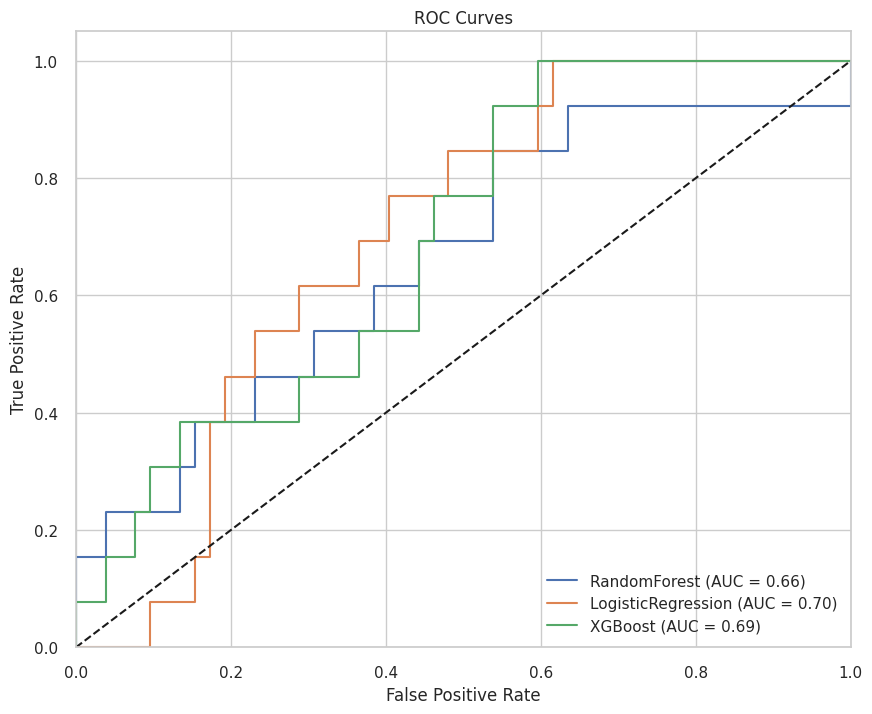

In [ ]:
def evaluate_models(results, X_test, y_test, label_encoder):

    metrics = ['accuracy', 'f1', 'log_loss']
    comparison = pd.DataFrame(index=results.keys(), columns=metrics)

    for model_name, result in results.items():
        for metric in metrics:
            comparison.loc[model_name, metric] = result[metric]

    print("\n=== Model Comparison ===")
    print(comparison)

    plt.figure(figsize=(10, 8))
    for model_name, result in results.items():
        if hasattr(result['model'].named_steps['classifier'], 'predict_proba'):
            y_score = result['model'].predict_proba(X_test)

            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            for i in range(len(label_encoder.classes_)):
                fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int),
                                             y_score[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])

            fpr["micro"], tpr["micro"], _ = roc_curve(
                label_binarize(y_test, classes=range(len(label_encoder.classes_))).ravel(),
                y_score.ravel()
            )
            roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

            plt.plot(fpr["micro"], tpr["micro"],
                     label=f'{model_name} (AUC = {roc_auc["micro"]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.savefig('roc_curves.png')
    plt.show()

    return comparison

comparison = evaluate_models(results, X_test, y_test, label_encoder)

#### 12. Model Interpretation with SHAP

<Figure size 1200x800 with 0 Axes>

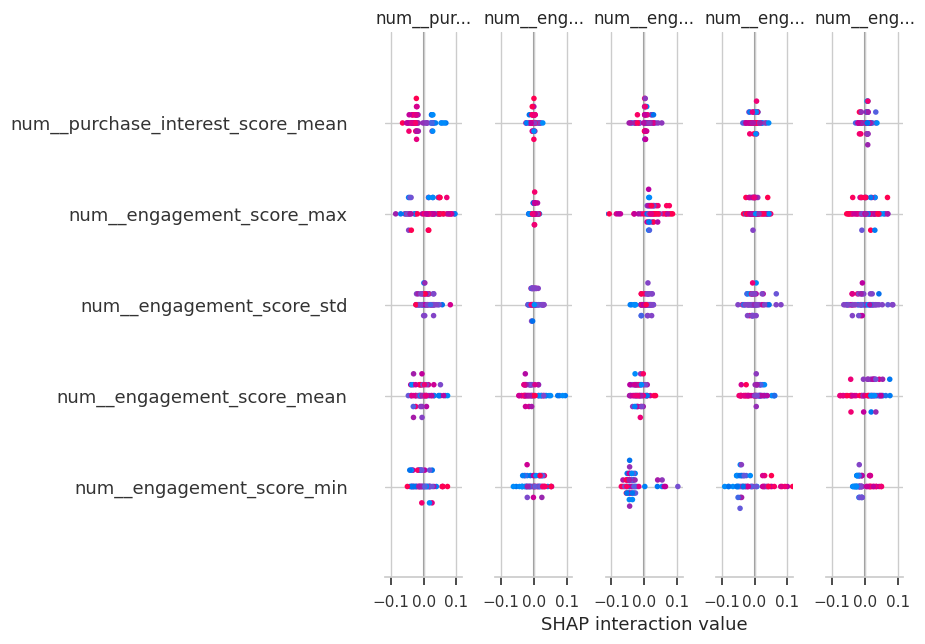

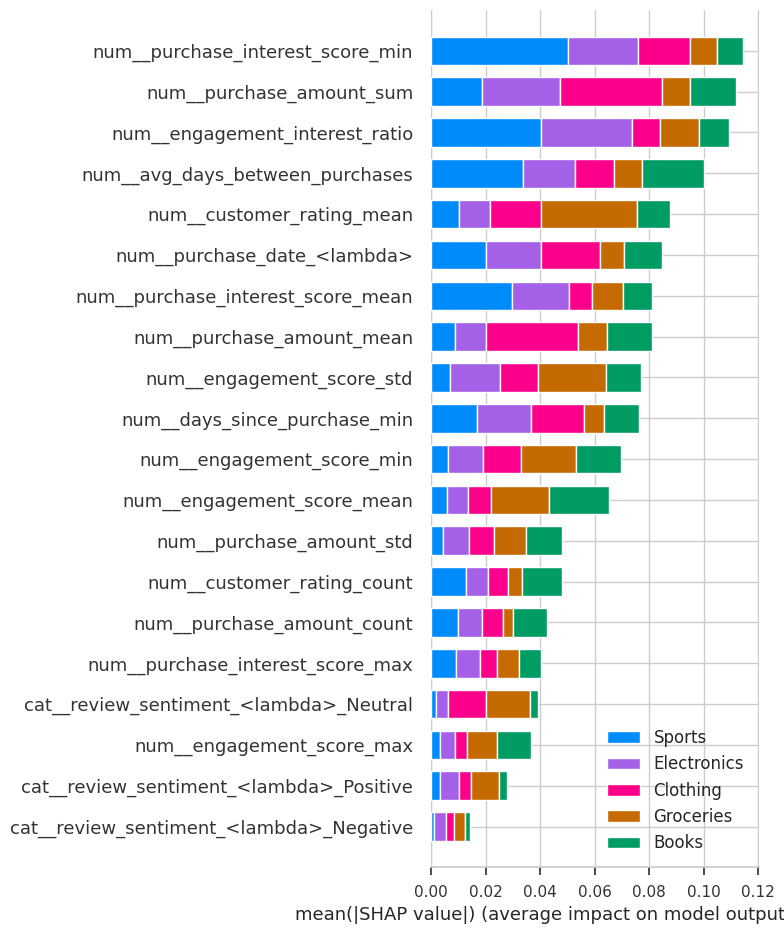

<Figure size 800x550 with 0 Axes>

In [ ]:
def interpret_model(best_model, X, feature_names, class_names):

    preprocessor = best_model.named_steps['preprocessor']
    X_processed = preprocessor.transform(X)

    if hasattr(preprocessor, 'get_feature_names_out'):
        feature_names_out = preprocessor.get_feature_names_out()
    else:
        feature_names_out = feature_names

    explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
    shap_values = explainer.shap_values(X_processed)

    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_processed,
                     feature_names=feature_names_out,
                     class_names=class_names,
                     show=False)
    plt.tight_layout()
    plt.savefig('shap_summary.png')
    plt.show()

    plt.figure(figsize=(12, 6))
    shap.summary_plot(shap_values, X_processed,
                     feature_names=feature_names_out,
                     plot_type="bar",
                     class_names=class_names)
    plt.tight_layout()
    plt.savefig('shap_feature_importance.png')
    plt.show()

best_model_name = max(results, key=lambda x: results[x]['f1'])
best_model = results[best_model_name]['model']
interpret_model(best_model, X, numerical_cols + categorical_cols, label_encoder.classes_)

#### 13. Save Models and Artifacts
Here, the best perfoming model and the model comparison results are saved to a CSV file, ensuring that the trained model and associated data can be reused or deployed later.

In [ ]:
def save_artifacts(results, label_encoder, numerical_cols, categorical_cols):

    best_model_name = max(results, key=lambda x: results[x]['f1'])
    best_model = results[best_model_name]['model']

    joblib.dump(best_model, 'best_model.pkl')

    joblib.dump(label_encoder, 'label_encoder.pkl')

    feature_info = {
        'numerical_cols': numerical_cols,
        'categorical_cols': categorical_cols,
        'target': 'product_category'
    }
    joblib.dump(feature_info, 'feature_info.pkl')

    comparison = pd.DataFrame()
    for model_name, result in results.items():
        comparison.loc[model_name, 'Accuracy'] = result['accuracy']
        comparison.loc[model_name, 'F1 Score'] = result['f1']
        comparison.loc[model_name, 'Log Loss'] = result['log_loss']

    comparison.to_csv('model_comparison.csv')
    print("Artifacts saved successfully!")

save_artifacts(results, label_encoder, numerical_cols, categorical_cols)

Artifacts saved successfully!


#### 14. Prediction Function
This cell calls the predict_product_category function, which allows for making predictions on new customer data using the saved best model. An example usage of this function is also provided, demonstrating how to get predictions for a sample customer.

In [ ]:
def predict_product_category(customer_data, model_path='best_model.pkl',
                           label_encoder_path='label_encoder.pkl',
                           feature_info_path='feature_info.pkl'):
    """
    Predict product category for a new customer.

    Args:
        customer_data (dict): Dictionary containing customer features
        model_path (str): Path to saved model
        label_encoder_path (str): Path to label encoder
        feature_info_path (str): Path to feature info

    Returns:
        dict: Prediction results with probabilities
    """

    model = joblib.load(model_path)
    label_encoder = joblib.load(label_encoder_path)
    feature_info = joblib.load(feature_info_path)

    input_df = pd.DataFrame([customer_data])

    try:
        prediction = model.predict(input_df)[0]
        probabilities = model.predict_proba(input_df)[0]

        top3_indices = np.argsort(probabilities)[-3:][::-1]
        top3_categories = label_encoder.inverse_transform(top3_indices)
        top3_probs = probabilities[top3_indices]

        return {
            'status': 'success',
            'prediction': label_encoder.inverse_transform([prediction])[0],
            'confidence': float(np.max(probabilities)),
            'top_predictions': dict(zip(top3_categories, top3_probs)),
            'all_probabilities': dict(zip(
                label_encoder.classes_,
                [float(p) for p in probabilities]
            ))
        }
    except Exception as e:
        return {
            'status': 'error',
            'message': str(e)
        }

# Example
if __name__ == "__main__":
    print("\n=== Example Prediction ===")
    sample_customer = {
        'engagement_score_mean': 75.5,
        'engagement_score_std': 10.2,
        'engagement_score_max': 85.0,
        'engagement_score_min': 65.0,
        'purchase_interest_score_mean': 4.2,
        'purchase_interest_score_max': 4.8,
        'purchase_interest_score_min': 3.5,
        'review_sentiment_<lambda>': 'Positive',
        'purchase_amount_mean': 250.5,
        'purchase_amount_sum': 1002.0,
        'purchase_amount_count': 4,
        'purchase_amount_std': 50.2,
        'customer_rating_mean': 4.2,
        'customer_rating_count': 4,
        'days_since_purchase_min': 15,
        'purchase_date_<lambda>': 30,
        'engagement_interest_ratio': 17.98,
        'avg_days_between_purchases': 3.75
    }

    prediction = predict_product_category(sample_customer)
    print("\nSample Prediction:")
    for key, value in prediction.items():
        if isinstance(value, dict):
            print(f"\n{key}:")
            for k, v in value.items():
                if isinstance(v, float):
                    print(f"  {k}: {v:.4f}")
                else:
                    print(f"  {k}: {v}")
        else:
            print(f"{key}: {value}")

    print("\n=== Analysis Complete ===")


=== Example Prediction ===

Sample Prediction:
status: success
prediction: Clothing
confidence: 0.38033028842004474

top_predictions:
  Clothing: 0.3803
  Books: 0.2974
  Groceries: 0.1510

all_probabilities:
  Books: 0.2974
  Clothing: 0.3803
  Electronics: 0.1464
  Groceries: 0.1510
  Sports: 0.0249

=== Analysis Complete ===


### Conclusion

In conclusion, this analysis aimed to predict customer product categories based on social profiles and transaction data. While a comprehensive machine learning pipeline was implemented, the dataset was small in size, which limited the models from achieving high predictive performance. Increasing the amount of data would be an essential next step to build a more effective product category prediction system.